In [1]:
#make necesarry imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

# Forecasting

In [6]:
df = pd.read_csv("forecasting_data.csv")
df

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118
5,6,9139
6,7,12460
7,8,10717
8,9,7825
9,10,9693


## 1. Visualize and interprete the pattern of this time-series

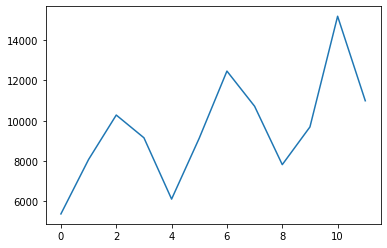

In [3]:
plt.plot(df["Sales"])
plt.show()

Answer: We can see from this data that some months are much better/higher sales figures than the others and each quarter was stronger than the previous.

## 2. Predict future demand in the four next quarters without seasonality

### Using moving average

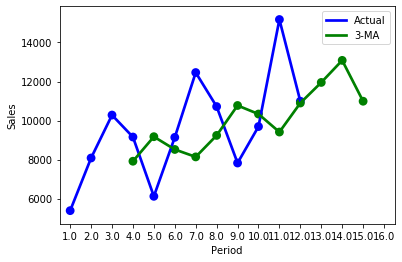

In [4]:
# Using moving average
def moving_average(df, k, to_period):
    moving_average_df = pd.DataFrame(columns=['Period','Sales'])
    for m in range(0, to_period):
        if m < k:
            sales_pred = float('nan')
        else: 
            history = df["Sales"][m-k:m]
            sales_pred = history.mean()
        moving_average_df.loc[m] = [m+1, sales_pred]
    return moving_average_df

f, ax = plt.subplots(1, 1)
ma_df = moving_average(df, 3, 16)
sns.pointplot(x='Period', y='Sales', data=df, color='b')
sns.pointplot(x='Period', y='Sales', data=ma_df, color='g')
ax.legend(handles=ax.lines[::len(df)+1], labels=["Actual", "3-MA"])
plt.show()

### Using exponential smoothing

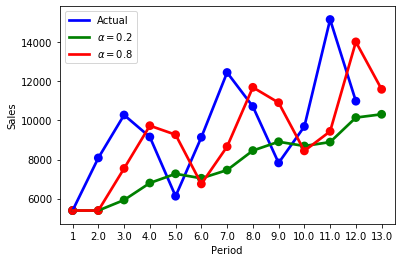

In [5]:
def exponential_smoothing(df, alpha):
    es_df = pd.DataFrame(columns=['Period','Sales']) #an empty dataframe with columns Period and Sales from our dataframe to work on to calculate the expo smoothing
    es_df.loc[0] = [1, df["Sales"][0]] #our fisrt row

    for m in range(0, len(df)): 
        prediction = alpha * df["Sales"][m] + (1 - alpha) * es_df["Sales"][m]
        es_df.loc[m+1] = [m+2, prediction]
    return es_df


f, ax = plt.subplots(1, 1)
es_df_02 = exponential_smoothing(df, 0.2)
es_df_08 = exponential_smoothing(df, 0.8)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])
plt.show()

## 3. Predict future demand in the four next quarters with seasonality

Cycle 1     8225.75
Cycle 2     9608.50
Cycle 3    10921.25
dtype: float64
      Cycle 1   Cycle 2   Cycle 3       Avg
Seq                                        
1    0.654530  0.636728  0.716493  0.669250
2    0.982403  0.951137  0.887536  0.940359
3    1.249977  1.296768  1.389676  1.312141
4    1.113090  1.115367  1.006295  1.078251


/Users/bernardo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RankWarning: Polyfit may be poorly conditioned


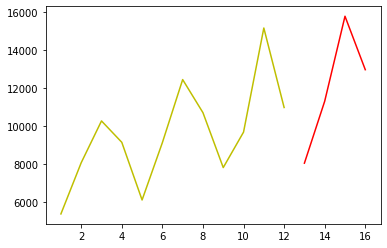

In [7]:
#season function
def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'Cycle 2'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'Cycle 3'
    else:
        return 'Cycle 1'
def get_seq(row):
    return row['Period']%4 and row['Period']%4 or 4

def predict_with_seasonality(df, months):
    new_df = df.copy()   #make a copy of our dataframe
    new_df['Season'] = new_df.apply(get_season, axis=1)
    new_df['Seq'] = new_df.apply(get_seq, axis=1)
    
    season_df = pd.DataFrame((new_df.pivot('Seq','Season')['Sales']).to_records())
    season_df.index = season_df['Seq']
    season_df = season_df.drop(['Seq'], axis=1)
    
    #print(season_df)
    avg_df = season_df.apply(np.mean)
    print(avg_df)
    seasonal_index_df = pd.DataFrame(columns=['Cycle 1','Cycle 2','Cycle 3'])
    seasonal_index_df['Cycle 1'] = season_df["Cycle 1"]/avg_df["Cycle 1"]
    seasonal_index_df['Cycle 2'] = season_df["Cycle 2"]/avg_df["Cycle 2"]
    seasonal_index_df['Cycle 3'] = season_df["Cycle 3"]/avg_df["Cycle 3"]
    seasonal_index_df['Avg'] = seasonal_index_df.mean(axis=1) #axis=1 to calculate the mean for each row
    print(seasonal_index_df)
    

    #conduct linear regression
    season = np.array([1,2,3])
    avg_arr = np.array([avg_df['Cycle 1'], avg_df['Cycle 2'], avg_df['Cycle 3']])
    fit = np.polyfit(season, avg_arr, 3)
    poly = np.poly1d(fit)
    average_predict = poly(4)

    #dataframe to store the predictions itself
    forecast_df = pd.DataFrame(columns=['Period','Sales'])
    forecast_df['Sales'] = seasonal_index_df["Avg"] * average_predict
    forecast_df['Period'] = months #passed as parameters in a list when callind the function predict_with_seasonality
    forecast_df.index = np.array(months) - 1
    return forecast_df

season_df = predict_with_seasonality(df, [13,14,15,16])

f, ax = plt.subplots(1, 1)
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(season_df['Period'], season_df['Sales'], c='r')
plt.show()

# 4.Evaluation: compare the above implemented methods

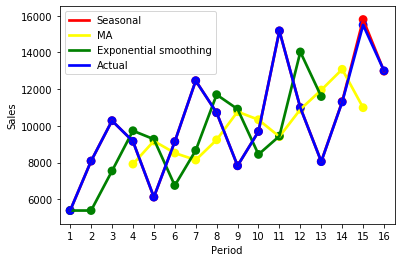

In [12]:
eval_df = pd.read_csv('forecasting_actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index=True)

f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=pd.concat([df, season_df], ignore_index=True), color='r')
sns.pointplot(ax=ax, x='Period', y='Sales', data=ma_df, color='yellow')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='green')
sns.pointplot(ax=ax, x='Period', y='Sales', data=eval_df, color='b')
ax.legend(handles=ax.lines[::len(df)+5], labels=["Seasonal", 'MA', "Exponential smoothing", "Actual"])
plt.show()

We can see that the Actual and the prediction using the Seasonal are on point.

In [32]:
MAD = np.absolute(eval_df["Sales"][12:16] - moving_average(eval_df, 3, 16)["Sales"][12:16]).mean()
print("MAD of {0}: {1}".format("3-MA", MAD))
MAD = np.absolute(eval_df["Sales"][12:16] - exponential_smoothing(eval_df, 0.2)["Sales"][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD))
MAD = MAD = np.absolute(eval_df["Sales"][12:16] - exponential_smoothing(eval_df, 0.8)["Sales"][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.8", MAD))
MAD =np.absolute(eval_df["Sales"][12:16] - season_df["Sales"][0:4]).mean()
print("MAD of {0}: {1}".format("Seasonality Method", MAD))

MAD of 3-MA: 2694.75
MAD of Exponential smoothing with alpha=0.2: 2707.7580143305513
MAD of Exponential smoothing with alpha=0.8: 3088.7232615120074
MAD of Seasonality Method: 85.88221407247443


In [34]:
MSE = (eval_df["Sales"][12:16] - moving_average(eval_df, 3, 16)["Sales"][12:16])**2
MSE = MSE.mean()
print("MSE - Mean Squared Error of {0}: {1}".format("3-MA", MSE))

MSE = (eval_df["Sales"][12:16] - exponential_smoothing(eval_df, 0.2)["Sales"][12:16])**2
MSE = MSE.mean()
print("MSE - Mean Squared Error of {0}: {1}".format("Exponential smoothing with alpha = 0.2", MSE))


MSE = (eval_df["Sales"][12:16] - exponential_smoothing(eval_df, 0.8)["Sales"][12:16])**2
MSE = MSE.mean()
print("MSE - Mean Squared Error of {0}: {1}".format("Exponential smoothing with alpha = 0.8", MSE))


MSE = (eval_df["Sales"][12:16] - season_df["Sales"][0:4])**2
MSE = MSE.mean()
print("MSE - Mean Squared Error of {0}: {1}".format("Seasonality Method", MSE))

MSE - Mean Squared Error of 3-MA: 11544241.36111111
MSE - Mean Squared Error of Exponential smoothing with alpha = 0.2: 9744054.271861337
MSE - Mean Squared Error of Exponential smoothing with alpha = 0.8: 10909182.694821384
MSE - Mean Squared Error of Seasonality Method: 22206.08964632366
